# An analysis of friendships and betrayals using the online game "Diplomacy"

> Arthur Bricq, Dianne Marquette, Taavet Kangur

This notebook presents the work done on a big dataset of about 22'000 Diplomacy games. It contains the following sections :
- **I**. Introduction to Diplomacy
- **II**. Discovering the dataset
- **III**. A little data pre-processing won't hurt us
- **IV**. Friendships and Betrayals
- **V**. Data Generation for later analysis
- **VI**. Machine Learning Analysis: can we predict betrayals using game features and a simple classifier ?
- **VII**. Data story plots 

## 0. Reading the data

In this section, we explain how to read the dataset. 

Our dataset can be found [here](https://data.world/maxstrange/diplomacyboardgame).

During our analysis, we realized that 'units' have a duplication problem. For several games, all units were replicated. Hence, we remove those. By precaution, we also remove duplicates for orders and for turns. 

In [1]:
import pandas as pd
import time
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

# constant to save plots
SAVE_PLOT = True

In [2]:
# read dataframes
all_games = pd.read_pickle("data/games.pkl")
all_orders = pd.read_pickle("data/orders.pkl")
all_players = pd.read_pickle("data/players.pkl")
all_turns = pd.read_pickle("data/turns.pkl")
all_units = pd.read_pickle("data/units.pkl")

# remove duplicates
all_units = all_units.drop_duplicates()

In [3]:
all_games.head(3)

,id,num_turns,num_players
0,37317,166,7
1,37604,51,7
2,39337,101,7


# I. Introduction to Diplomacy.

What we want to do here is **to detect betrayals within a game**, using the same definitions as in the paper we have studied. Let's recall a few things, and we will explore the dataset based on those definitions.

## What are game actions ? 

Each player has **units** (one per each city a player controls) and those are moved using **orders**. There are two kinds of orders: 
- **support** : two units join to form a bigger (i.e. stronger) one. One player can support another.
- **move**: move a unit somewhere. If it meets another player's unit, it will be a **battle**

## How to define relationships ? 

Let's follow the definitions given by the paper.

**Act of friendship**: when a player supports another.

**Act of hostility**: When a player invades another, or supports an invasion to the other player's territory.

**Friendship**: a relationship between two players spanning over **three** seasons containing at least **two consecutive and reciprocated** acts of friendship.

**Betrayal** / **Broken friendship**: When, after being in a friendship, two players engage in at least 2 acts of hostility. 

## Additional information

It is important to understand the [rules of the game](https://www.playdiplomacy.com/help.php?sub_page=Game_Rules).

Here is a list of points, obtained from looking at the rules, we want to raise before starting programming.
- Each **year** is broken down into two **seasons**: {'Spring', 'Fall'}.
- Each **season** is itself divided into several phases, called **turns** (therefore, a year is made of at least two turns, and not more than five):
    - **orders**: each player submit orders to all of his/her units (that can be **hold**, **move**, **support** or **convoy**)
    - **retreats**: a phase that happens when some units (called **disloged units**) need to retreat. If they can't, they are destroyed
    - **builds**: only happens after the *fall retreat*. Players gain control of **supply centers**  they are occupying.
- Geographically, the game is divided into **provinces**.
- Some provinces are called **supply centers** (SCS) and to win, a **player** must control 18 supply centers.
- Each **unit** belongs to a **player** and there can be **only one unit** in a province at a time, however **units** can join their force with the **support** order.
- There are two types of **units**:  {'F' or 'A'} for {Fleet, Army}.
- Each **player** is characterized by his/her country, encoded by a letter: {E,F,I,G,A,T,R} standing for {England, France, Italy, Germany, Austria, Turkey, Russia}.

We also give a clarification for the rows of 'all_orders' (i.e. the proper orders) because we will be using those quite a lot, and it can be hard to understand. 
- Orders are defined by a **game_id**, a **unit_id** and a **turn_number** (which makes sense, considering all the above points). 
- Each order has a field **location** which is the province of origin of the unit.
- Depending on the **unit_order**, here is the description of the fields.

| unit_order | location                 | target                            | target_dest     |
| ---------- | ------------------------ | --------------------------------- | --------------- |
| MOVE       | initial loc. of the unit | loc. to move to                   | null            |
| HOLD       | initial loc. of the unit | null                              | null            |
| CONVOY     | initial loc. of the unit | initial loc.                      | end goal loc.   |
| SUPPORT    | initial loc. of the unit | loc. of unit to be supported      | its target loc. |
| BUILD      | initial loc. of the unit | encoded string like 'army Berlin' |                 |
| RETREAT    | initial loc. of the unit | target loc                        |                 |
| DESTROY    | initial loc. of the unit |                                   |                 |

It is also interesting to look at the map which contains all the **locations** where **units** can move. 

<img src="img/map.png" width="700">

# II. Discovering the Dataset

Now that all of this is well-defined, let's see what we can achieve in the code. As it can be quite hard to see how to do this, let's break this down and look at one game.

In [4]:
# extract one game
# 37317
# 120600
game = all_games.query("id == 37317")
game_id = game.iloc[0,0]
game

,id,num_turns,num_players
0,37317,166,7


In [5]:
# for this game, extract turns, orders and units
turns = all_turns.query("game_id == {}".format(game_id))
orders = all_orders.query("game_id == {}".format(game_id))
units = all_units.query("game_id == {}".format(game_id))
orders.head()

,game_id,unit_id,unit_order,location,target,target_dest,success,reason,turn_num
11451415,37317,0,MOVE,Edinburgh,North Sea,None,1,None,1
11451416,37317,1,MOVE,Liverpool,Belgium,None,0,Illegal order replaced with Hold order,1
11451417,37317,2,HOLD,London,None,None,1,None,1
11451418,37317,3,MOVE,Marseilles,Spain,None,1,None,1
11451419,37317,4,MOVE,Paris,Burgundy,None,0,Bounced,1


## Can we find **acts of friendship** ?

It's firstly defined by a support. However, it is not enough: a player could support himself/herself (and that's not a friendship). So we must also look at the **last previous orders** asking to **MOVE** the unit towards the support's **target** destination. This will link to a 'unit_id' (the one that followed this order) and therefore giving access to the country that made the call.

In [6]:
# first we must look at the supports that happened in this game.
supports = orders.unit_order == "SUPPORT"
orders_w_supports = orders[supports]
orders_w_supports.sample(3)

,game_id,unit_id,unit_order,location,target,target_dest,success,reason,turn_num
11452781,37317,36,SUPPORT,Gulf of Lyons,Marseilles,Spain,1,None,31
11452939,37317,30,SUPPORT,Kiel,Munich,Munich,1,None,33
11452610,37317,20,SUPPORT,Berlin,Silesia,Silesia,1,None,26


In [7]:
# we want to find the countries of the supported units
# let's take one and see what we can do
support_order = orders_w_supports.iloc[-4]
# support_order = orders_w_supports.head(3).tail(1)
support_order

game_id                             37317
unit_id                                12
unit_order                        SUPPORT
location                          Galicia
target                             Vienna
target_dest                       Bohemia
success                                 0
reason         Support cut by a war - gal
turn_num                               33
Name: 11452914, dtype: object

In [8]:
# Example: there is a support from 'Vienna' to 'Bohemia' 
# we know that in one of the previous orders, someone made a move with 'Vienna' as the destination
target = support_order.target#.values[0]
turn_number = support_order.turn_num#.values[0]
move_order = orders.query("unit_order == 'MOVE' & target == '{}' & turn_num < {}".format(target, turn_number)).tail(1)
move_order

,game_id,unit_id,unit_order,location,target,target_dest,success,reason,turn_num
11451517,37317,20,MOVE,Galicia,Vienna,None,0,Bounced,3


In [9]:
unit_id = move_order.unit_id.values[0]
move_unit = units.query("unit_id == {}".format(unit_id))
move_unit

,game_id,country,type,start_turn,end_turn,unit_id
1035275,37317,R,A,0,45,20


We see that Russia was the country that had moved its army there the last time before a support happened. Hence, 'Russia is the supported country'.

In [10]:
# Let's look at the country who did the support
unit_id = support_order.unit_id# .values[0]
support_unit = units.query("unit_id == {}".format(unit_id))
support_unit

,game_id,country,type,start_turn,end_turn,unit_id
1035256,37317,A,A,0,110,12


It turns out that this **is** an act of friendship: Russia was supported by Austria, when it moved from Vienna to Bohemia, by Austrian soldiers who were in Galicia. As we can see on the map, this is perfectly coherent with the geographical position of provinces.

# III. Some data pre-processing won't hurt us

Now is when we realize it would be nice to have extra information about orders. This can be seen as a pre-processing step since it will be computed only once. Once we have a more 'understandable' dataset, we will first compute some descriptive statistics and then try to train a classifier.

## Required additional fields

The first thing that we want is to know is **what country passed which order** and also **the year and the season at which each order was passed**, in order to find friendships with more precision than if we use only 'year' as an indicator of when an order occurs. Here is how we encode seasons using *yearly indication*: 
- the spring of a year is written as the year; for instance, 'Spring 1904' = 1904
- the fall of the same year is written as the year + 0.5; for instance, 'Fall 1904' = 1904.5

Also, let's note that there is sometimes a problem with the data. Order with id == 89268, for instance, has the 'units' that are duplicated. A  possible way to solve this is to run `units.drop_duplicates()`. It's not the only potential problem with the 'unit' array. Indeed sometimes we encounter duplicates that are almost exactly the same, but not exactly. The end turn would be slightly different. The solution to this problem is simply to expect an error and, if one is caught, to skip this game.

In [11]:
try: 
    # 1. compute the country who emitted each order 
    countries = orders.unit_id.apply(lambda x: units.query("unit_id == {}".format(x)).country.item())
    # compute the 'encoded year' in which each order was passed
    turns["season_encoded"] = turns["year"] + 0.5 * (turns["season"] == "Fall")
    years = orders.turn_num.apply(lambda x: turns.query("turn_num == {}".format(x)).season_encoded.item())
    # update the orders
    orders["country"] = countries
    orders["year"] = years
except ValueError:
    print("Data is corrupted and execution was aborted")

Finally, the last piece of information that we need (and that is harder to obtain) is **the 'target country': towards which player (if any) was this action intended ?**. When an order is passed, there is often another country located at the order's target. This information is essential for us. Let's find it here.

In [12]:
def get_target_country(order, orders):
    """
    Given an order MOVE or SUPPORT, it returns the country that controls the targeted province.
    The function looks at 'the last successful move towards the targeted province'.
    If none is found, it returns None.
    If order is not MOVE or SUPPORT, it returns an empty string.
    """
    if order.unit_order not in ["MOVE", "SUPPORT"]: return ""
    # get the last move orders to this province
    q = "(unit_order in ('MOVE' ,'RETREAT', 'HOLD')) & success == 1 & target == '{}' & turn_num < {}".format(order.target, order.turn_num)
    last_move_orders = orders.query(q)
    if len(last_move_orders):
        # extract the order
        last_move_order = last_move_orders.iloc[-1]
        return last_move_order.country
    else:
        # this is when there never was a successful move toward this province
        return "None"

In [13]:
# get the target country
targets = orders.apply(lambda o: get_target_country(o, orders), axis = 1)
orders["target_country"] = targets
orders.sample(5)

,game_id,unit_id,unit_order,location,target,target_dest,success,reason,turn_num,country,year,target_country
11452268,37317,33,RETREAT,Galicia,Ukraine,None,1,None,19,A,1904.5,
11451870,37317,28,MOVE,Vienna,Galicia,None,0,Bounced,11,A,1903.0,R
11452629,37317,43,MOVE,St. Petersburg,Norway,None,1,None,26,R,1906.0,R
11452797,37317,38,HOLD,Vienna,None,None,1,None,31,A,1907.0,
11452887,37317,37,MOVE,Spain,Marseilles,None,1,None,33,I,1907.5,F


# IV. Friendships and Betrayals

Now that we have a good dataframe that is a lot nicer to work with, let's start the actual data-processing to find friendships and betrayals. As one will see, it turns out to be harder than expected. 

## Finding **acts of friendship**

This function is just a rewriting of all the code which was presented above.

Note that we don't add the query criteria 'success == 1' because it's not the result that defines the act's intention. You can plan to attack someone and fail; you will still have performed a hostile action towards the other player.

In [14]:
def is_order_act_of_friendship(support_order):
    # only interested in SUPPORT orders to other countries
    if support_order.unit_order != "SUPPORT": return False
    if support_order.target_country == "None": return False
    return support_order.country != support_order.target_country

In [15]:
# so we may add this to the orders dataframe
acts_of_friendships = orders.apply(is_order_act_of_friendship, axis = 1)
acts_of_friendships.value_counts()

False    461
True      21
dtype: int64

Good news : it's working. As we see, there is another column 'acts_friendships' which tell if this order was an act of friendships-

## Finding **acts of hostility**

The code is very similar, only the logic is a little tweaked. 

We are looking at all **orders** with **unit_order** that is **MOVE** (*this is how an attack starts*), where the **target** is a province with a unit of another player. Again, the tricky part is to see if another player's unit is located in this province. We must look at all the **previous orders** with the same **target** done by a unit from **another country**.

In [16]:
def is_move_act_of_hostility(move_order):
    if move_order.unit_order != "MOVE": return False
    if move_order.target_country == "None": return False
    return move_order.country != move_order.target_country

In [17]:
acts_of_hostility = orders.apply(is_move_act_of_hostility, axis = 1)
acts_of_hostility.value_counts()

False    410
True      72
dtype: int64

## Who is friends with who

Now that we have classified our orders, let's find friends within our game. Coming back to our definition:

> Friendship is a relationship between two players spanning over 3 seasons containing at least 2 consecutives and reciprocated acts of friendships.


In [18]:
friendly_orders = orders[acts_of_friendships]
hostile_orders = orders[acts_of_hostility]

For each order in the above set, assuming the 'supporting country' is X and the 'supported country' is Y, we must look if there exists in the last 2 years: 
- at least 2 previous orders with 'X supports Y'
- at least 2 previous orders with 'Y supports X'

If those criteria are met, the concerned acts of friendship are part of an actual **friendship**.

Let's create a table that will recap all friendships and potential betrayals, and then let's fill it up with the data already extracted. Those tables are called the **friendship matrix**, and they are crucial for our analysis. They contain:
- 21 columns, as for the 21 possible friendships between the 7 players (friendships are reciprocal: 'XY' = 'YX')
- the rows correspond to seasons within a game
- 1s when 2 players are engaged in a friendship and 0s if there are no longer friends
- a letter, designing one of the 2 players who committed the betrayal (we must add a non-binary indication here because the friendship XY is the same as YX, and we want to know who committed the betrayal)

In [19]:
def get_countries_code(x,y):
    """Given two countries, it returns another string being their letters sorted alphabetically.
    This string is the 'encoded friendship name'."""
    return ''.join(sorted(x + y))

In [20]:
countries = ['A', 'E', 'F', 'G', 'I', 'R', 'T']
pairs = [x+y for x in countries for y in countries if y > x]
years = np.arange(1901, max(friendly_orders.year.max(), hostile_orders.year.max()) + 0.5, 0.5)
# create a dataframe each possible friendships and each years
friendships = pd.DataFrame(columns=pairs, index = years, dtype = np.int8).fillna(0)
friendships.head(3)

,AE,AF,AG,AI,AR,AT,EF,EG,EI,ER,...,FG,FI,FR,FT,GI,GR,GT,IR,IT,RT
1901.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1901.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1902.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's also do a little function to make some prints about a friendship matrix of 1 game. It is used for debugging.

In [21]:
def analyse_friendships(df):
    """Given the friendship dataframe, it will extract insights out of it"""
    # get columns where something happened
    cols = [col for col in df.columns if np.count_nonzero(friendships[col] != 0)]
    if len(cols):
        print("- friendships:", cols)
        for c in cols: 
            tmp = df.loc[:,c]
            pos = tmp[tmp != 0].values
            # print(pos)
            if type(pos[-1]) is str: 
                print("    * length of friendship ",c," is ", len(pos) - 1)
                print("        ->",c," ends betrayed by ",pos[-1],"") 
            else: 
                print("    * length of friendship: ", len(pos))

    else:
        print("- No friendships were found")

Our first attempt to find friendships and betrayals led us to write those 2 functions. They work rather often, but not always. The problem with those functions is that friendships and betrayals are more linked than one could think at first. However, we decided to include them in this notebook as they were really helpful until we found the real solution. 

In [22]:
def find_friendships(friendships, friendly_orders, hostile_orders, length_year = 1.5):
    """Will fill the 'friendships' dataframe by adding '1's to signify that a pair of players engaged in a 
    reciprocal friendships
    
    Careful, the function doesn't return anything - instead it changes the 'friendship' dataframe
    
    Parameters
    friendships (pd.DataFrame): df with rows as 'encoded seasons' and columns as 'encoded friendship names'.
    friendly_orders (pd.DataFrame): df with all orders corresponding to 'acts of friendship'
    length_year (int): minimum amount of time that must elapse between the first AOF and the last one.
    
    Discussion
    For each order with an AOF, it will query all the other ones that 
    - happened before
    - involving exactly the same 2 countries
    Then it makes sure that among all those orders
    - each player originated at least 2 of them
    - that the time elapsed between the first one and the last one was longer than `length_year` 
    Those orders are the ones defining a friendship.
    """
    # for each friendly order, finds those that define a friendship
    for i, o in friendly_orders.iterrows():
        x, y, year = o.country, o.target_country,  o.year
        # this line doesn't remove frienships because we are only looking at reciprocal ones
        if y > x: continue
        # make a query over others friendly orders from the past (including this one !)
        q = "year <= @year & ( (country == @x & target_country == @y) | (country == @y & target_country == @x) )"
        query = friendly_orders.query(q)
        # extract number of mutual supports between these 2 countries
        n_x = np.count_nonzero(query.country == x)
        n_y = len(query) - n_x
        y_min = query.year.min()
        y_max = query.year.max()
        # print("output of query: ",get_countries_code(x,y), y_min, y_max)
        if n_x >= 2 and n_y >= 2 and (y_max - y_min) >= length_year:
            # they meet all criteria about 'being nice to each other'
            code = get_countries_code(x,y)
            friendships.loc[query.year.min():o.year, code] = 1
            # we just want to make sure they are not 'being not nice' as well ! 
            # each time we find an AOH, we must break the friendship at this year
            q = "year < @y_max & year > @y_min & country in (@x, @y) & target_country in (@x, @y)"
            query = hostile_orders.query(q)
            for i, hostile_order in query.iterrows(): 
                # print("   hostile act detected ", code, hostile_order.year, hostile_order.unit_id)
                friendships.loc[hostile_order.year, code] = 0            
    

In [23]:
def find_betrayals(friendships, hostile_orders, N_hostile_min = 2):
    """Will fill the 'friendships' dataframe by removing '1' when a friendship was broken and if a 
    betrayal is detected, it will add its country letter to the frame. 
    
    Careful, the function doesn't return anything - instead it changes the 'friendship' dataframe
    
    Parameters
    friendships (pd.DataFrame): df with rows as 'encoded seasons' and columns as 'encoded friendship names'.
    hostile_orders (pd.DataFrame): df with all orders corresponding to 'acts of hostility'
    N_hostile_min (int): minimum number of hostile actions to consider this event as a betrayal
    
    Discussion
    For each order, if the players were engaged in a friendship, it will first end the friendship and 
    then verifiy that this event is considered a betrayal by our definition.
    """
    for i, o in hostile_orders.iterrows():
        x = o.country
        y = o.target_country
        code = get_countries_code(x,y)
        if friendships.loc[o.year, code]:
            # 1. it breaks the friendship
            friendships.loc[o.year+0.5:, code] = 0 
            # 2. did a betrayal happened ? 
            # we must just verify that another hostile action happened after this
            q = "year >= {}  & ((country == @x & target_country == @y) | (country == @y & target_country == @x) )".format(o.year, x, y)
            query = hostile_orders.query(q)
            if len(query) >= N_hostile_min: 
                # print("   - betrayal happened for ", code)
                friendships.loc[o.year, code] = x 

In [24]:
# let's test those functions
years = np.arange(1901, max(friendly_orders.year.max(), hostile_orders.year.max()) + 0.5, 0.5)
friendships = pd.DataFrame(columns=pairs, index = years, dtype = np.int8).fillna(0)
find_friendships(friendships, friendly_orders, hostile_orders)
find_betrayals(friendships, hostile_orders)
print(friendships[[c for c in friendships.columns if np.count_nonzero(friendships[c])]])
analyse_friendships(friendships)

         AI
1901.0  0.0
1901.5  0.0
1902.0  0.0
1902.5  0.0
1903.0  0.0
1903.5  0.0
1904.0  0.0
1904.5  1.0
1905.0  0.0
1905.5  1.0
1906.0  1.0
1906.5  1.0
1907.0  1.0
1907.5  1.0
- friendships: ['AI']
    * length of friendship:  6


As we can see here, there is something wrong with this code (*this example was selected to illustrate a game not working*). In this friendship (game 37317), there is a problem in the year 1904 for the friendship 'AI'. It is hard to fix this problem with the current approach, and we had to leave it behind. Let's show our better approach to solve the **friendship identification problem**.

### Finding Friendships Algorithm

The final algorithm to find friendships and betrayals is rather complex, so here is a high-level explanation of what it does.

*Abbreviations used recurrently in the code*
- AoF = "Act of friendship"
- AoH = "Act of hostility"

The algorithm's main idea is to consider a series of AoFs that we call '**bags of AoF**'. Those bags, with what separates them, is what must be analyzed. Let's define 2 criteria: one internal criterion and one external criterion that 'bags of AoF' must verify in order to be part of an actual friendship.

a. **Internal criteria** that a bag of AOFs must verify (*internal* because it only depends on the AoFs)
- more than 2 acts emitted by the 2 countries
- the overall time elapsed is longer than 1.5 years

b. **External criterion** that a bag of AoFs must verify (*external* because the criterion depends on the AoHs that happened at the same time)
- no AoH in the same time range


The algorithm includes the following steps:

**For each pair of countries** (*their friendship is represented by a column of the 'friendships' dataframe*): 
1. Find all AoFs that happened between them. Consider them like a bag of AoFs. 
2. Verify that this 'bag of acts of friendships' (BAOF) verifies the *internal criteria* mentioned above. If so, fill all cells between the first season and the last season with '1's. Else, make sure '0's are placed at the seasons of interest. 
3. Find acts of hostility that happened between the same time range as the bag of words. Split the bag of words (*actually, it's the seasons array that is split*) for every act of hostility so that we obtain 
4. For each bag of AoF (hence, uninterrupted by hostility, so external validity is verified !) verify internal validity again. If not verified, replace '1's with zeros.
5. Find betrayal, as the event:  "breaking a bags of AoFs with more than 1 hostile action".


Let's note that since step 3 doesn't need to be repeated, it is not a recursive algorithm. Recursive approaches were also tried, but they turned out to be a lot harder than this. 

Before implementing this algorithm, we need a 'splitting' function that is also a little tricky to find. There are several ways to do this splitting properly (recursive splitting would be one way) but we will use a vectorized approach. **We want to split a list of 'ones' divided by zeros into a list of 'bags' of ones**. Let's just show how one can do that here using the power of **numpy**. 

In [25]:
# illustration of the splitting algorithm 
ones = np.array([1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.])
delta = ones[1:] - ones[:-1]
idcs = np.where(delta != 0)[0]+1
bags = np.split(ones, idcs)
bags

[array([1.]),
 array([0., 0.]),
 array([1., 1., 1.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([1.])]

As we can see, it works well ! Let's just write a few functions for those tasks, and then we can implement the overall algorithm safely.

In [26]:
length_year = 1.5
countries = ['A', 'E', 'F', 'G', 'I', 'R', 'T']
pairs_tuple = [(x,y) for x in countries for y in countries if y > x]

def are_AOFs_friendship(AOFs, x, y, length_year = 1.0, n_xy_min = 2, n_min = 4):
    """Internal validity criteria:
    Given a dataframe of 'AoF's, and the 2 countries of interest, 
    it returns the validity of this series of friendly actions. 
    """
    if not len(AOFs): return False, None, None
    # extract number of mutual supports between these 2 countries
    n_x = np.count_nonzero(AOFs.country == x)
    n_y = len(AOFs) - n_x
    # extract information about the year
    y_min = AOFs.year.min()
    y_max = AOFs.year.max()
    # print(get_countries_code(x,y), y_min, y_max)
    return (n_x >= n_xy_min and n_y >= n_xy_min and (n_x + n_y) >= n_min and (y_max - y_min) >= length_year), y_min, y_max

def get_bags_of_ones_idcs(ones):
    """Given a numpy array of ones, returns the indices where to split the array 
    so that all ones are together and all zeros are together, in sub arrays, once split."""
    delta = ones[1:] - ones[:-1]
    idcs = np.where(delta != 0)[0]+1
    return idcs

Here is the infamous function. Readers can now note the last parameter of the code: N_hostile_min (*is often referred to as N later on*), which is **the minimum number of acts of hostility required so that a broken friendship becomes a betrayal**. Intuitively, one would say that N = 1 is the best candidate (at least, it seems to us). However, the original paper suggested using N = 2, probably to only select betrayals that are **harder** in terms of consequences over the friendship. Since we were not sure about this parameter, we decided to declare it as a hyperparameter in our analysis, and later a graph will analyze its effect.

In [27]:
def find_friendships_and_betrayals(friendships, friendly_orders, hostile_orders, N_hostile_min = 2, ):
    """Fills the 'friendships' dataframe by adding '1's to signify that a pair of players engaged in a 
    reciprocal friendship.
    
    Careful, the function doesn't return anything - instead it changes the 'friendships' dataframe
    which is the friendship matrix of the provided game. 
    
    Parameters
    friendships (pd.DataFrame): df with rows as 'encoded seasons' and columns as 'encoded friendship names'.
    friendly_orders (pd.DataFrame): df with all orders corresponding to 'acts of friendship'
    length_year (int): minimum amount of time that must elapse between the first AoF and the last one.
    N_hostile_min (int): min number of AoH so that a broken friendship is considered a betrayal. 
    """
    for pair in pairs:
        # 1. make a query for all acts of support of this pair of countries    
        x, y = pair
        q = "country in (@x, @y) & target_country in (@x, @y)"
        query1 = friendly_orders.query(q)
        # 2. verify internal validity of AoFs
        is_valid, y_min, y_max = are_AOFs_friendship(AOFs = query1, x = x, y = y)
        if is_valid:
            # Fill with '1' everywhere
            code = get_countries_code(x,y)
            friendships.loc[y_min:y_max, code] = 1
            # Look for acts of hostility
            q = "year < @y_max & year > @y_min & country in (@x, @y) & target_country in (@x, @y)"
            query2 = hostile_orders.query(q)
            # Each time we find an AoH, break the friendship at this season
            for i, hostile_order in query2.iterrows(): 
                friendships.loc[hostile_order.year, code] = 0    
            # Verify again that each small bag of AoFs is valid or not
            # a. get the indices using the values 
            idcs = get_bags_of_ones_idcs(friendships.loc[y_min:y_max, code].values)
            # b. and make the split using the indices of the dataframe
            bags_of_years = np.split(friendships.loc[y_min:y_max, code].index.values, idcs)
            # c. loop inside even (not odd) bags of years (the other ones are those with betrayals)
            # we know the first one '0' will be containing a friendship, that's why we can do this
            for years in bags_of_years[::2]: 
                AoFs = query1.query("year in @years")
                # print(AoFs[["year","unit_order", "country", "target_country"]], "\n")
                is_valid, _, _ = are_AOFs_friendship(AOFs= AoFs, x = x, y = y, n_xy_min = 1, n_min = 3)
                if not is_valid:
                    # this friendship is cancelled
                    friendships.loc[years, code] = 0  
            # Final step: find betrayals inside odd bags of years
            for years in bags_of_years[1::2]:
                # first, verify it's coming after a friendship
                if friendships.loc[years[0]-0.5, code]:   
                    # get the hostile orders in the desired time interval 
                    AoHs = query2.query("year in @years")
                    if len(AoHs) >= N_hostile_min:
                        # betrayal happened here ! 
                        betrayal = AoHs.iloc[0]
                        friendships.loc[betrayal.year, code] = betrayal.country

In [28]:
# let's test this function
years = np.arange(1901, max(friendly_orders.year.max(), hostile_orders.year.max()) + 0.5, 0.5)
friendships = pd.DataFrame(columns=pairs, index = years, dtype = np.int8).fillna(0)
find_friendships_and_betrayals(friendships, friendly_orders, hostile_orders, N_hostile_min=1)
print(friendships[[c for c in friendships.columns if np.count_nonzero(friendships[c])]])
analyse_friendships(friendships)

         AI
1901.0  0.0
1901.5  0.0
1902.0  0.0
1902.5  0.0
1903.0  0.0
1903.5  0.0
1904.0  0.0
1904.5  0.0
1905.0  0.0
1905.5  1.0
1906.0  1.0
1906.5  1.0
1907.0  1.0
1907.5  1.0
- friendships: ['AI']
    * length of friendship:  5


Good news: the detection of friendships is finally working, and everything is done inside one function. 

**Note for debugging**: *it is possible to nicely visualize in a terminal the 'friendships' dataframe and the orders with the following commands**
- to display the acts of friendship: `friendly_orders[["year", "country", "target_country"]]`
- same by filtering for 2 countries: `friendly_orders[["year", "country", "target_country"]].query("country in ('E', 'G')")`
- or even the more complete `friendly_orders[["year", "country", "target_country"]].query("country in ('E', 'G') and target_country in ('E', 'G')")` 
- to display friendships that matter: `friendships[[c for c in friendships.columns if np.count_nonzero(friendships[c])]]`

## Scaling to several games

Until now, we have only been looking at a single game. We must start to scale our analysis to gain a broader perspective. Let's see what we can do. The first thing to do is make the process a little more functional by defining methods for each step of the process.

In [29]:
def get_dataframes(game_id):
    orders = all_orders.query("game_id == {}".format(game_id))
    turns = all_turns.query("game_id == {}".format(game_id))
    units = all_units.query("game_id == {}".format(game_id))
    return orders, turns, units

In [30]:
def get_empty_friendships(max_year):
    countries = ['A', 'E', 'F', 'G', 'I', 'R', 'T']
    pairs = [x+y for x in countries for y in countries if y > x]
    years = np.arange(1901, max_year + 0.5, 0.5)
    # create a dataframe with each possible friendship as columns and each year as rows
    return pd.DataFrame(columns=pairs, index = years, dtype = np.int8).fillna(0)

In [31]:
def process_orders(orders, turns, units):
    try:
        # 1. find the country that emitted each order 
        countries = orders.unit_id.apply(lambda x: units[["unit_id", "country"]].query("unit_id == {}".format(x)).country.item())
        orders["country"] = countries
        # 2. compute the 'encoded year' at which each order was passed
        turns["season_encoded"] = turns["year"] + 0.5 * (turns["season"] == "Fall")
        years = orders.turn_num.apply(lambda x: turns.query("turn_num == {}".format(x)).season_encoded.item())
        orders["year"] = years
        # 3. get the target countries
        targets = orders.apply(lambda o: get_target_country(o, orders), axis = 1)
        orders["target_country"] = targets
        return True
    except ValueError:
        print("Data is corrupted, and execution was aborted")
        return False

In [32]:
def analyse_game(game, verbose = False):
    # get the dataframes and process them
    orders, turns, units = get_dataframes(game_id = game.id.item())
    has_succeeded = process_orders(orders, turns, units)
    if not has_succeeded: return None, None, None
    
    # find the acts of friendships / hostility
    acts_of_friendships = orders.apply(is_order_act_of_friendship, axis = 1)
    acts_of_hostility = orders.apply(is_move_act_of_hostility, axis = 1)
    friendly_orders = orders[acts_of_friendships]
    hostile_orders = orders[acts_of_hostility]
    if verbose:
        print("- {} acts of friendship and {} acts of hostility over {} orders ".format(len(friendly_orders), len(hostile_orders), len(orders)))
    
    # construct the friendship matrix
    if len(friendly_orders) and len(hostile_orders):
        friendships = get_empty_friendships(max_year = max(friendly_orders.year.max(), hostile_orders.year.max()))
        find_friendships_and_betrayals(friendships, friendly_orders, hostile_orders, N_hostile_min=1)
        return friendships, friendly_orders, hostile_orders
    else: 
        return None, None, None

Now that we have all our functions, we can verify that we obtain the same results as before (and the answer is "yes we do")

In [33]:
game = all_games.query("id == 37317")
friendships, _, _ = analyse_game(game)
if friendships is not None:
    analyse_friendships(friendships)
else:
    print("No acts of friendship or no acts of hostility")

- friendships: ['AI']
    * length of friendship:  5


We may now try to use those functions to process more games ! 

In [34]:
# let's run this function N times
N = 5
games_sample = all_games.query("num_turns >= 60").sample(N)
for i, game in games_sample.iterrows(): 
    print("\n*** Game {} ***".format(game.id.item()))
    friendships, _, _ = analyse_game(game)
    if friendships is not None:
        analyse_friendships(friendships)


*** Game 107143 ***
- friendships: ['AI', 'GR']
    * length of friendship:  14
    * length of friendship:  23

*** Game 58972 ***
- friendships: ['EF']
    * length of friendship  EF  is  20
        -> EF  ends betrayed by  E 

*** Game 90995 ***
- friendships: ['ER', 'IT', 'RT']
    * length of friendship  ER  is  7
        -> ER  ends betrayed by  R 
    * length of friendship:  3
    * length of friendship:  5

*** Game 121448 ***
- friendships: ['EG']
    * length of friendship  EG  is  6
        -> EG  ends betrayed by  E 

*** Game 97223 ***
- friendships: ['AT']
    * length of friendship:  17


By doing so, one observes that according to our definition, **not all games contain friendships** and that **most friendships end with a betrayal**. This makes sense with the 'game's mindset'. Here is a quote from the creators of the game. No wonder we observe a lot of betrayals.

> "Luck plays no part in Diplomacy. Cunning and cleverness honesty and perfectly-timed betrayal are the tools needed to outwit your fellow players. The most skillful negotiator will climb to victory over the backs of both enemies and friends. Who do you trust?"

We also notice that, in many games, there are very few acts of friendship (at least, there are many more acts of hostility than acts of friendship). For instance, the game '91 843' includes 1002 orders, and only '2' of them were considered acts of friendship. We guess that there are two types of games: those with many alliances and betrayals, and those with more personal strategies where players do not coordinate a lot. **We are only interested in this first type of games**, so we will filter the games to only keep the relevant ones for our analysis. The next section of this notebook will go through the procedure to generate the datasets used for further statistical analysis.

# V. Dataset Generation 

As the dataset is massive and the data-processing is computationally very expensive, we decided to generate smaller datasets only containing the data we care about. We generate two different datasets:
1. A subset of the initial dataset that can be filtered to only include games with friendships.
2. A dataset with 'season features' that is used by our classifier (everything is explained below).

## 1. Subset from the original dataset

The next block of code generates a portion of the dataset as NumPy objects to analyze them more easily later down the road. It randomly samples games that have more than 50 turns, because longer games tend to have more friendships (that's about half of all games, as one can see with the .describe function), and if the game has a friendship, it's going to save (i) its game_id and (ii) the generated friendship array as a NumPy array (.npy file).

In [35]:
# we see that the median number of turns per game is 46
all_games.num_turns.describe()

count    21197.000000
mean        47.029391
std         16.776897
min          2.000000
25%         36.000000
50%         46.000000
75%         56.000000
max        467.000000
Name: num_turns, dtype: float64

In [36]:
# hyper-parameters
N = 5
num_turns_min = 0 
game_should_have_friendships = False
verbose = False

# code starts here
n_games = N
game_ids = []
all_friendships = []
games_feature = []

s = time.time()
games = all_games.query("num_turns >= @num_turns_min")
while n_games:
    game = games.query("id not in @game_ids").sample(1)
    game_id = game.id.item()
    friendships, friendly, hostile = analyse_game(game, verbose = verbose)
    if friendships is not None:
        cols = [col for col in friendships.columns if np.count_nonzero(friendships[col] != 0)]
        # create a boolean condition depending on the hyperparameters 
        condition = len(cols) if game_should_have_friendships else True
        if condition:
            print("#games to find: ", n_games)
            n_games -= 1
            game_ids.append(game_id)
            all_friendships.append(friendships.values)
            games_feature.append((len(friendly), len(hostile), game.num_turns.item()))
            
            if verbose:
                print("A valid GAME was found: ", game_id)
                analyse_friendships(friendships)
                print("")
e = time.time()

print("elapsed: ", e-s)

## TO SAVE:  UNCOMMENT THIS
#np.save("data/subset_T{}_N1_unfiltered/games_id.npy".format(N), np.array(game_ids))
#np.save("data/subset_T{}_N1_unfiltered/games_features_id.npy".format(N), np.array(games_feature, dtype=object))
#np.save("data/subset_T{}_N1_unfiltered/friendships.npy".format(N), np.array(all_friendships, dtype=object))

#games to find:  5
#games to find:  4
#games to find:  3
#games to find:  2
#games to find:  1
elapsed:  15.812840938568115


## 2. Feature generation for machine learning analysis

Let's generate some features that we can later analyze using machine learning methods. 

We want to have 250 betrayals and 250 lasting friendships. However, it is not the friendships that we care about, but it is rather the seasons of each friendship. Indeed, we want to detect if a player will betray his/her ally during the next season, hence, the 'input' of the classifier will be each season of each of those games.

The first thing to do is write a function `get_features` which, given a friendship and its context (hence the actions of the involved players), returns the inputs of the machine learning classifier (either to train or to test). The classifier that we want to train must take as input a season and return as output **if a betrayal happens during the next season**.

**Feature selection is hard**, and unfortunately, we couldn't find a set of features that yield good results, partly because of lack of time. Here is the list of features that we used:
- length of the friendship at this season
- number of acts of \textbf{hostility} of each of the two involved players towards all other players at this season
- number of acts of \textbf{support} of each of the two involved players towards all other players at this season
- average number of mutual supports of the two involved players towards each other for the last three seasons

This is a total of 8 features for each game season. 

In [37]:
def get_xy(code, seasons): 
    """Given a friendship code and an array of seasons, it will return the betrayer and the victim.
    If no betrayal occurred, it picks randomly who is what. 
    """
    # find x and y
    xy = list(code)
    if type(seasons[-1]) == str: 
        x = seasons[-1]
    else:
        x = xy[np.random.randint(2)]
    xy.remove(x)
    y = xy[0]
    return x,y

In [38]:
# features as an array
columns = ["game_id", "has_betrayal", "length", "outcome" ,"n_aoh_x", "n_aoh_y", "n_aos_x", "n_aos_y", "supports_xy" , "supports_yx"]


def get_features(game_id, has_betrayal, friendship, friendly_orders, hostile_orders):
    """
    Given the friendships' column representing 1 friendship and several other parameters about the context,
    it will create all the feature vectors for each season, and will return them all together 
    as a Pandas dataframe. 
    
    Parameters
    game_id (int)
    has_betrayal (bool)
    friendship (pd.Serie): column representing the friendship in the friendships dataframe
    friendly_orders: all the friendly orders of this game
    hostile_orders: all the hostile orders of this game
    
    Notations
    X = 'betrayer'
    Y = 'betrayed' = 'victim'
    """
    # n = len(friendship[friendship != 0])
    n = len(friendship[friendship == 1])
    features = pd.DataFrame(data=np.zeros(shape=(n, len(columns))),columns = columns)
        
    
    # find the betrayals inside this friendship
    betrayals = [type(s) == str for s in friendship]
    code = friendship.name
    # some very rare games have more than 1 betrayal: 90346
    # hence we split the friendship into its sub-components
    splitted = np.split(friendship.values, np.where(betrayals)[0]+1)    

    # i: iterator over rows inside the features dataframe
    # j: iterator inside the splitted array we are using
    # s: iterator over each splitted array we are using
    i,j,s = 0,0,0
    for year, season in friendship.iteritems():
        if not season: continue
            
        if type(season) == str: 
            # a betrayal occurred --> let's pass to the next splitted
            features.loc[i-1,"outcome"] = 1
            s += 1
            j = 0
        else:
            # it means this is a season where: 
            # - the 2 playes are engaged in a friendship
            # - there is no betrayal (yet...)
            x,y = get_xy(code, splitted[s])
            # 1. Easy features
            features.loc[i,"game_id"] = game_id
            features.loc[i,"has_betrayal"] = has_betrayal
            features.loc[i,"length"] = j+1
            features.loc[i,"outcome"] = 0
            # 2. number of acts of hostility
            # a. n_aoh_x
            h_query = hostile_orders.query("country == @x & year == @year")
            features.loc[i,"n_aoh_x"] = len(h_query)
            # b. n_aoh_y
            h_query = hostile_orders.query("country == @y & year == @year")
            features.loc[i,"n_aoh_y"] = len(h_query)
            # 3. number of AoS emitted towards other players 
            # a. n_aos_x
            f_query = friendly_orders.query("country == @x & target_country != @y & year == @year")
            features.loc[i,"n_aos_x"] = len(f_query)
            # a. n_aos_y
            f_query = friendly_orders.query("country == @y & target_country != @x & year == @year")
            features.loc[i,"n_aos_y"] = len(f_query)
            # 4. Average number of mutual supports during the last 3 seasons
            # y to x
            supports_yx = friendly_orders.query("country == @y & target_country == @x & year <= @year & year > (@year-1.5)"
                                               ).groupby("year").apply(len)
            if len(supports_yx): features.loc[i,"supports_yx"] = supports_yx.mean()
            # x to y 
            supports_xy = friendly_orders.query("country == @x & target_country == @y & year <= @year & year > (@year-1.5)"
                                               ).groupby("year").apply(len)
            if len(supports_xy):features.loc[i,"supports_xy"] = supports_xy.mean()
            # last. increment steppers
            i += 1 
            j += 1
            
    return features    

This block of code is only used for debugging (we want to verify that we compute good features). It only creates the variables required to test the `get_features`, as shown below.

In [39]:
# try this fonction with one game in particular 
# IDs with several betrayals: 90346, 86785, 103566, 100325
game = all_games.query("id == 86785")
game_id = game.id.item()
friendships, friendly_orders, hostile_orders = analyse_game(game, verbose = True)
cols = [col for col in friendships.columns if np.count_nonzero(friendships[col] != 0)]
c = cols[0]
friendship = friendships[c]
get_features(game_id,True , friendship, friendly_orders, hostile_orders)

- 41 acts of friendship and 239 acts of hostility over 1077 orders 


,game_id,has_betrayal,length,outcome,n_aoh_x,n_aoh_y,n_aos_x,n_aos_y,supports_xy,supports_yx
0,86785.0,True,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0
1,86785.0,True,2.0,0.0,3.0,1.0,0.0,1.0,1.0,0.0
2,86785.0,True,3.0,0.0,3.0,2.0,0.0,0.0,1.0,0.0
3,86785.0,True,4.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0
4,86785.0,True,5.0,1.0,2.0,2.0,0.0,0.0,1.0,1.0


Now that we know what features to extract and how to do so, let's do that many times over 2N games. We then save the results into the pickle format to later use this data for training and testing our classifier. 

In [40]:
### Code to generate our machine learning dataset
# HYPERPARAMETERS
N = 2
verbose = False

# code starts here
visited_ids = []
n_betrayal, n_no_betrayal = N,N
features = pd.DataFrame(data=np.zeros(shape=(0, len(columns))),columns = columns)

s = time.time()
games = all_games.query("num_turns >= 50")
while n_betrayal or n_no_betrayal:
    # get one game
    game = games.query("id not in @visited_ids").sample(1)
    game_id = game.id.item()
    visited_ids.append(game_id)
    
    # perform our analysis on this game, and test for skip condition
    friendships, friendly_orders, hostile_orders = analyse_game(game, verbose = verbose)
    if friendships is None: continue
        
    # extract the columns that matters, and test for skip condition
    cols = [col for col in friendships.columns if np.count_nonzero(friendships[col] != 0)]
    if not len(cols): continue
    
    # for each friendship:
    for c in cols:
        friendship = friendships[c]
        # 1. check if there is a betrayal
        if type(friendship[friendship != 0].iloc[-1]) == str:
            # there is a betrayal
            if n_betrayal: 
                # 2. get the features
                game_features = get_features(game_id, True, friendship, friendly_orders, hostile_orders)
                features = pd.concat([features, game_features])
                n_betrayal -= 1
                # todo: find features
        else:
            # there is no betrayal
            if n_no_betrayal:
                # 2. get the features
                game_features = get_features(game_id, False, friendship, friendly_orders, hostile_orders)
                features = pd.concat([features, game_features])
                # there wasn't a betrayal
                n_no_betrayal -= 1    
            
    print("#games still to find:  {} with betrayals and {} without betrayals".format(n_betrayal, n_no_betrayal))
    if verbose:
        print("A valid GAME was found: ", game_id)
        analyse_friendships(friendships)
        print("")
e = time.time()

print("elapsed: ", e-s)

## UNCOMMENT to save
# features.to_pickle("data/features_B10_V10_N1/features.pkl")
features.head()

#games still to find:  2 with betrayals and 1 without betrayals
#games still to find:  0 with betrayals and 1 without betrayals
#games still to find:  0 with betrayals and 1 without betrayals
#games still to find:  0 with betrayals and 0 without betrayals
elapsed:  29.65506625175476


,game_id,has_betrayal,length,outcome,n_aoh_x,n_aoh_y,n_aos_x,n_aos_y,supports_xy,supports_yx
0,76749.0,False,1.0,0.0,0.0,4.0,0.0,0.0,2.0,0.0
1,76749.0,False,2.0,0.0,2.0,2.0,0.0,2.0,2.0,3.0
2,76749.0,False,3.0,0.0,2.0,0.0,1.0,0.0,2.5,2.0
0,95173.0,True,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,95173.0,True,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


# VI. Machine Learning Analysis: can we predict betrayals using game features ? 

As explained above, we collected some features from the game seasons of many friendships, and we now want to create **a classifier in order to predict if a betrayal will happen in the next season**. We try to perform logistic regression with our collected features.

To train the data, we use a dataset of 200 games with a betrayal. Let's note that even if we only select games with a betrayal, most of the seasons are not labeled with `outcome = 1`. Indeed, for most seasons during a friendship, a betrayal doesn't occur during the following season. What we want to classify is not if a betrayal will happen at some point in the game, but it is if a betrayal will occur during **the next season**. 

In [41]:
import statsmodels.formula.api as smf
from sklearn.metrics import (confusion_matrix, accuracy_score, plot_confusion_matrix) 

features = pd.read_pickle("data/features_B200_V0_N1/features.pkl")
features.head(2)

,game_id,has_betrayal,length,outcome,n_aoh_x,n_aoh_y,n_aos_x,n_aos_y,supports_xy,supports_yx
0,54754.0,True,1.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0
1,54754.0,True,2.0,0.0,1.0,4.0,0.0,0.0,1.0,1.0


We must normalize our predictors before classifying the seasons. We must also keep track of the mean and standard deviations of each of the predictors of the training dataset to reuse them later when normalizing the testing set that we generated separately (and therefore doesn't have the same means/variances).

In [42]:
# 1. Normalisation of the features. 
predictors = ["length", "n_aoh_x", "n_aoh_y","n_aos_x", "n_aos_y", "supports_xy", "supports_yx"]
features = features[predictors + ["outcome"]]

def get_means_and_stds(features, predictors):
    """Given the features and the predictors, returns all the means and stds for the provided predictors"""
    means = []
    stds = []
    for p in predictors: 
        means.append(features[p].mean())
        stds.append(features[p].std())
    return means, stds

def normalise_preds(features, predictors, means, stds):
    """Features normalisation with a provided mean and stds for each predictor"""
    for i, p in enumerate(predictors): 
        features[p] = (features[p] - means[i]) / stds[i]
        
        
means, stds = get_means_and_stds(features, predictors)
normalise_preds(features, predictors, means, stds)

In [43]:
# 2. Create the regression formula
formula = "outcome ~ " + ' + '.join(predictors)
formula

'outcome ~ length + n_aoh_x + n_aoh_y + n_aos_x + n_aos_y + supports_xy + supports_yx'

In [44]:
# 3. Make the regression
mod = smf.logit(formula = formula, data = features)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.370756
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                 1580
Model:                          Logit   Df Residuals:                     1572
Method:                           MLE   Df Model:                            7
Date:                Fri, 18 Dec 2020   Pseudo R-squ.:                 0.07336
Time:                        23:02:06   Log-Likelihood:                -585.79
converged:                       True   LL-Null:                       -632.17
Covariance Type:            nonrobust   LLR p-value:                 3.359e-17
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.0005      0.083    -24.208      0.000      -2.162      -1.839
length          0.5082    

## Classification Assessment

The best pseudo-R-squared we could achieve was 7%.

Now that we have fitted a regression model, it is quite hard to interpret the summary. However, we can use additional metrics to see if our model behaves as we want. For this purpose, we generated another set of points: the testing dataset, which only included 20 games where at least one betrayal happens. We want to see if we can detect those betrayals at the right season.

Let's also focus our attention on the seasons where a real betrayal occurred, and let's see if this classifier worked properly. For this reason, we evaluate our model results for the seasons of the testing set with betrayals.

The first metric we can look at is the [accuracy score](https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score).

In [45]:

# 1. read the test dataset
features_test = pd.read_pickle("data/features_B20_V0_N1/features.pkl")
normalise_preds(features_test, predictors, means, stds)


X_test = features_test[predictors]
y_test = features_test["outcome"]


# 2. predict the values and get the binary output
predictions = res.predict(X_test)
binaries = (predictions.values >= 0.5).astype(float)
accuracy_score(y_test, binaries)


0.8465909090909091

We see that we obtain about 85% of accuracy on the test set, and about 86% on the train set. It looks good, No ? **Wait !** Is it really that good ? Well, not so much... It is possible to compare this result with **dummy estimators** to see if our models performs better than stupid ones. Here, there are some possibilities.
- The dumbest estimator will perform worse than this one. Indeed, guessing uniformly between either zero or one will give a 50% chance level to detect betrayals, when only trying to detect betrayals. So when looking dumbly at this task, it looks like what we have isn't that bad. However, such a result isn't so useful: indeed, **there is a strong imbalance in the class labels** and if a classifier says that only 50% of seasons are betrayal, it's a really bad. The reason it performs better here is because we selected only seasons where a betrayal happened.
- Another dummy estimator is a stratified one: it generates random predictions by respecting the training set class distribution. Such an estimator gets 77% of accuracy, meaning that our estimator is better than this too. 
- However, it's also possible to have a classifier that will always predict the **most-frequent** class of the training set (hence always 'no betrayal will happen') and this one gets 87.5% of accuracy, which is better than ours, even when seeing on the training set. 

In [46]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='stratified')
X_train = features[predictors]
y_train = features["outcome"]

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7613636363636364

So let's ask the reverse question: **how bad is it ?**. We can try to understand more using the **confusion matrix**. Here, betrayals are marked as negatives. The rows represent the actual classes (first row means no betrayal, second row means betrayal) and the columns represent the predicted class (first row means predicted as no betrayals, second row means predicted as betrayal).

array([[148,   6],
       [ 21,   1]])

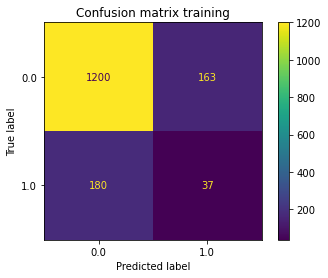

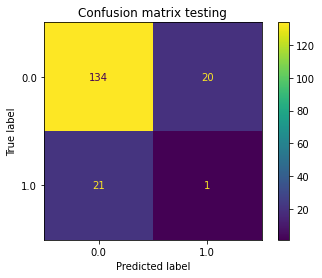

In [47]:
m = confusion_matrix(y_test, binaries)

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

training_matrix = plot_confusion_matrix(clf, X_train, y_train)
training_matrix = plt.title("Confusion matrix training")

if SAVE_PLOT:
    plt.savefig("plots/confusion_matrix_train.jpg")
    
testing_matrix = plot_confusion_matrix(clf, X_test, y_test)
testing_matrix = plt.title("Confusion matrix testing")

if SAVE_PLOT:
    plt.savefig("plots/confusion_matrix_test.jpg")
m

What do we observe ? The predictor has an overall accuracy of 85%: **this is better than random guess, however it is less than a most-frequent choice** . Because of the **strong class imbalance**, the accuracy isn't enough to determine, but we can look at the confusion matrix $C$ and see where does our classifier do the mistakes. 
- The second column of $C$ reveals that the accuracy of detecting betrayer is really low. Only one betrayal is detected on the test set, which is really not good at all. 
- The first row shows that $148 / 154 \approx 0.96 \%$ of non betrayal seasons are classifed as so. 
- We notice that 6 seasons that are non betrayal are detected as betrayals.

## Possible improvement

We believe that given more time, we could have found better results. At least, we really could have tried a lot more. Indeed, the data-processing to find betrayals was extremely time consuming and since we also had to invest time writing the data story and the report, we really didn't have many days working on the classifier. Here is a list of 'future plans' that we would have liked to do:
- Ask ourself the question, like what the authors of the paper did,: **is it the case because some betrayals are detected too early ?** (*Actually, looking at the data we realize that it is probably not the case...*)
- After looking at the prediction results, we noticed that, for a few games, many betrayals are detected, so we must answer to the question: **how can we enforce that there's only one betrayal per game ?** Adding this constraint is likely to increase the learning of the classifier. 
- Design better features
- Perform cross-validation for feature selection
- Have a more complex classifier. After all, humans are not able to perform well at this task, so it would not be suprising that even after doing all the previous steps and investing a lot of time on them, we realize that a linear classifier isn't able to do that. 

# VII. Datastory plots generation

From now on, the rest of the notebook is dedicated to generating plots and numbers for the datastory. 

## Descriptive statistics

We look at the **outcome** (binary) considering the **treatment**, which can be:
- engaged: player who was engaged in a friendship
- single: player who was not engaged in a friendship

And for engaged player, there is an additional treatment: 
- betrayer: player who betrayed another one
- betrayed: player who ended up betrayed by another
- neutral: player who was not engaged in a *broken* friendship

In order to answer this question, let's define a few functions that we will use in the later analysis.

In [48]:
countries = ['A', 'E', 'F', 'G', 'I', 'R', 'T']
pairs = [x+y for x in countries for y in countries if y > x]

In [49]:
def get_engageds(friendships):
    """Returns the players engaged in a friendship"""
    cols = [col for col in friendships.columns if np.count_nonzero(friendships[col] != 0)]
    return list(set(''.join(cols)))

def get_singles(engageds):
    """Returns players not engaged in a friendship"""
    singles = countries.copy()
    for engaged in engageds:
        singles.remove(engaged)
    return singles

In [50]:
def get_betrayers_and_betrayed(friendships):
    """Given the Friendships dataframe as defined in our analysis, returns all the players who commited 
    betrayals and all players who ended up betrayed"""
    cols = [col for col in friendships.columns if np.count_nonzero(friendships[col] != 0)]
    betrayers = []
    betrayeds = []
    for c in cols: 
        tmp = friendships[c]
        values = tmp[tmp != 0].values
        if type(values[-1]) == str: 
            betrayer = values[-1]
            betrayers.append(betrayer)
            tmp = list(c)
            tmp.remove(betrayer)
            betrayeds.append(tmp[0])
            
    return betrayers, betrayeds

def get_neutrals(betrayers, betrayeds):
    """Given betrayers and betrayeds players of a game, returns the list of players
    who were not involved in a broken friendship
    
    Required: player must be 'engaged'
    """
    neutrals = countries.copy()
    for b in betrayers: 
        if b in neutrals: neutrals.remove(b)
    for b in betrayeds: 
        if b in neutrals: neutrals.remove(b)
    return neutrals

In [51]:
def get_winners(game_id):
    winner = all_players.query("game_id == @game_id & won == 1")
    return winner.country.values

def get_losers(winners):
    loosers = countries.copy()
    for w in winners: loosers.remove(w)
    return loosers

In [52]:
# load the data to analyse
games_id = np.load("data/subset_T500_N1/games_id.npy")
all_friendships = np.load("data/subset_T500_N1/friendships.npy", allow_pickle=True)
verbose = False

data_overall = np.zeros(shape = (2,2))
data_engaged = np.zeros(shape = (3,2))

treatments_overall = ["single", "engaged"]
treatments_engaged = ["betrayer", "betrayed", "neutral"]
outcomes = ["winner", "loser"]

stats_overall = pd.DataFrame(data_overall, index = treatments_overall, columns = outcomes )
stats_engageds = pd.DataFrame(data_engaged, index = treatments_engaged, columns = outcomes )

N = len(games_id)
for i, game_id in enumerate(games_id):
    # reconstruct the obtained data
    data = all_friendships[i]
    years = np.arange(1901, 1901 + data.shape[0] * 0.5, 0.5)
    friendships = pd.DataFrame(data = all_friendships[i], columns = pairs, index = years)
    
    # get outcomes
    winners = get_winners(game_id)
    losers = get_losers(winners)
    
    # get treatment 1 
    engageds = get_engageds(friendships)
    singles = get_singles(engageds)
    
    # get treatment 2
    betrayers, betrayeds = get_betrayers_and_betrayed(friendships)
    neutrals = get_neutrals(betrayers, betrayeds)
    
    # overal statistics
    for w in winners:
        if w in singles: stats_overall.loc["single", "winner"] += 1
        if w in engageds: stats_overall.loc["engaged", "winner"] += 1
    for l in losers:
        if l in singles: stats_overall.loc["single", "loser"] += 1
        if l in engageds: stats_overall.loc["engaged", "loser"] += 1
    
    # statistics about betrayers: 
    for winner in winners: 
        if winner in engageds: 
            if winner in betrayers: stats_engageds.loc["betrayer", "winner"] += 1
            if winner in betrayeds: stats_engageds.loc["betrayed", "winner"] += 1
            if winner in neutrals: stats_engageds.loc["neutral", "winner"] += 1
    for loser in losers: 
        if winner in engageds:
            if loser in betrayers: stats_engageds.loc["betrayer", "loser"] += 1
            if loser in betrayeds: stats_engageds.loc["betrayed", "loser"] += 1
            if loser in neutrals: stats_engageds.loc["neutral", "loser"] += 1
            
    if verbose:
        print("\nGame",i)
        print("Winners: ", winners, " and Losers", losers)
        print("Betrayers: ", betrayers, " and Betrayed", betrayeds)
        print("Neutrals: ", neutrals)



In [53]:
win_ratio = stats_overall.winner / (stats_overall.loser + stats_overall.winner)
stats_overall["win_ratio"] = win_ratio
print("Statistics over all dataset")
stats_overall

Statistics over all dataset


,winner,loser,win_ratio
single,186.0,1947.0,0.087201
engaged,371.0,996.0,0.271397


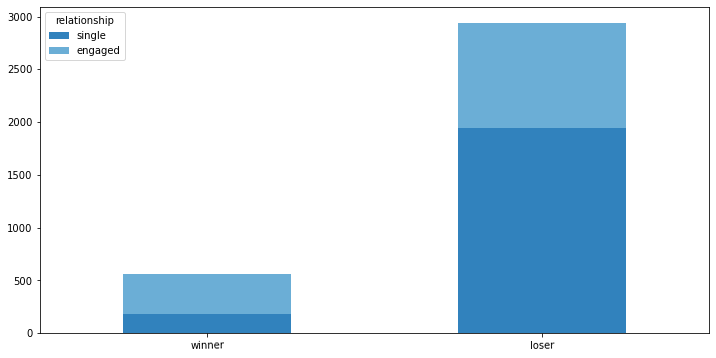

In [54]:
from matplotlib.colors import ListedColormap
import seaborn as sns

plot_stats_overall = stats_overall.drop(columns = 'win_ratio')
plot_stats_overall.index.set_names('relationship', inplace = True)

plot_stats_overall\
  .reindex(plot_stats_overall.sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True, rot=1,
          colormap=ListedColormap(sns.color_palette('tab20c', n_colors=2)), 
          figsize=(12,6));


if SAVE_PLOT:
    plt.savefig('plots/barplot_win_ratio_category_single_engaged.jpg')

In [55]:
win_ratio = stats_engageds.winner / (stats_engageds.loser + stats_engageds.winner)
stats_engageds["win_ratio"] = win_ratio
print("Statistics over players engaged in a friendship")
stats_engageds


Statistics over players engaged in a friendship


,winner,loser,win_ratio
betrayer,133.0,126.0,0.513514
betrayed,70.0,189.0,0.270270
neutral,171.0,1610.0,0.096013


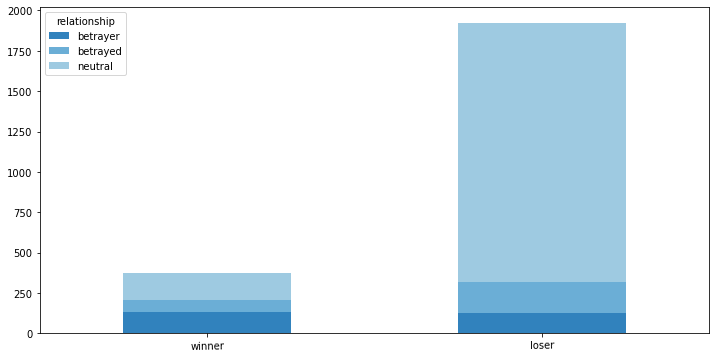

In [56]:
plot_stats_engageds = stats_engageds.drop(columns = 'win_ratio')
plot_stats_engageds.index.set_names('relationship', inplace = True)


plot_stats_engageds\
  .reindex(plot_stats_engageds.sum().sort_values().index, axis=1)\
  .T.plot(kind='bar', stacked=True, rot=1, 
          colormap=ListedColormap(sns.color_palette('tab20c', n_colors=3)),
          figsize=(12,6));

if SAVE_PLOT:
    plt.savefig('plots/barplot_win_ratio_category_fused.jpg')

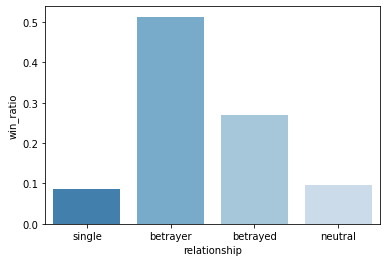

In [57]:
win_ratio_plot = pd.concat([stats_overall, stats_engageds])
win_ratio_plot.index.set_names('relationship', inplace = True)
win_ratio_plot

sns.barplot(data=win_ratio_plot.drop(index='engaged').reset_index(), 
            x='relationship', y='win_ratio',
           palette="tab20c");

if SAVE_PLOT:
    plt.savefig('plots/barplot_win_ratio_category.jpg')

What can we see here ? 
- among all players that were involved in a broken friendship (either *betrayer* or *betrayed*) the chances of winning go towards the betrayer. Betrayed players have much higher chances of loosing and about 5 times less chances of winning. . .. 
- the neutral players represent the majority of players, however their chances of winning are not much higher than the chances of betrayed players. 

These results make us strongly believe that **betrayals strongly influence the outcome of the game**. 

What can we do next ? 

- select 250 games with and without betrayals (and all with friendships), then do a matching based on the games properties, and look at what differs once a betrayal happened for the players who were engaged in a friendship !

- quantify agressivity of players towards others, and using the same dataset as before, try to see what happens to a player that was betrayed

## Difference between N1 and N2 for betrayals and for friendships counts



In [58]:
# 1. get the data
all_friendships_N1 = np.load("data/subset_T500_N1/friendships.npy", allow_pickle=True)
all_friendships_N2 = np.load("data/subset_T500_N2/friendships.npy", allow_pickle=True)

In [59]:
def get_number_betrayals_friendships(friendship): 
    cols = [col for col in range(21) if np.count_nonzero(friendship[:, col] != 0)]
    n_friendships = len(cols)
    n_betrayals = np.count_nonzero([type(e) == str for col in friendship for e in col])
    return n_friendships, n_betrayals

N = 500
frame = pd.DataFrame(data = np.zeros(shape = (4*N, 3)), columns = ["N", "type", "number",])

for i in range(N):
    n_friendships_n1, n_betrayals_n1 = get_number_betrayals_friendships(all_friendships_N1[i])
    n_friendships_n2, n_betrayals_n2 = get_number_betrayals_friendships(all_friendships_N2[i])
    frame.loc[4*i, :] = ["1", "friendships", n_friendships_n1]
    frame.loc[4*i+1, :] = ["1", "betrayals", n_betrayals_n1]
    frame.loc[4*i+2, :] = ["2", "friendships", n_friendships_n2]
    frame.loc[4*i+3, :] = ["2",  "betrayals", n_betrayals_n2]

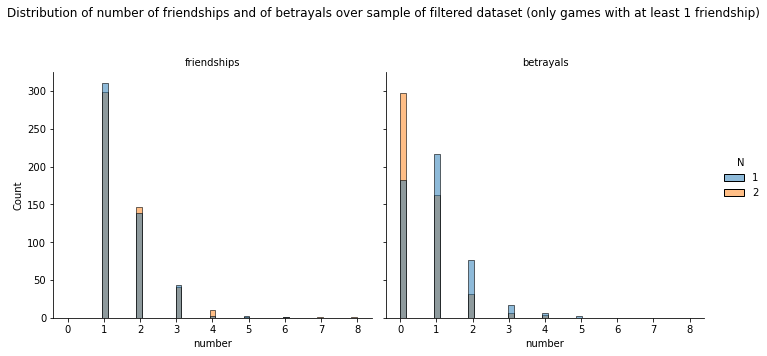

In [60]:
# make required the plot 
import seaborn as sns

g = sns.displot(data = frame, x = "number", hue = "N", kind = "hist", col = "type") ;
g.set_titles("{col_name}") ; 
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Distribution of number of friendships and of betrayals over sample of filtered dataset (only games with at least 1 friendship)") ; 

if SAVE_PLOT:
    plt.savefig('plots/distribution_friendships_filtered.jpg')


Increasing the requirement of a betrayal to two hostile acts considerabily reduce the number of games with betrayal from 300 to about 180 games. 

## Distribution of number of friendships and betrayals on the real dataset (without filtering) using N=1

This plot is quite like the previous plot, only difference is in the dataset. Here, we use the **unfiltered dataset**, meaning that we don't select games so that they have 1 friendship. 

In [61]:
# 1. get the data
all_friendships_unfiltered = np.load("data/subset_T500_N1_unfiltered/friendships.npy", allow_pickle=True)

In [62]:
N = 500
frame = pd.DataFrame(data = np.zeros(shape = (2*N, 2)), columns = ["type", "number",])
for i in range(N):
    n_friendships, n_betrayals = get_number_betrayals_friendships(all_friendships_unfiltered[i])
    frame.loc[2*i, :] = ["friendships", n_friendships]
    frame.loc[2*i+1, :] = ["betrayals", n_betrayals]

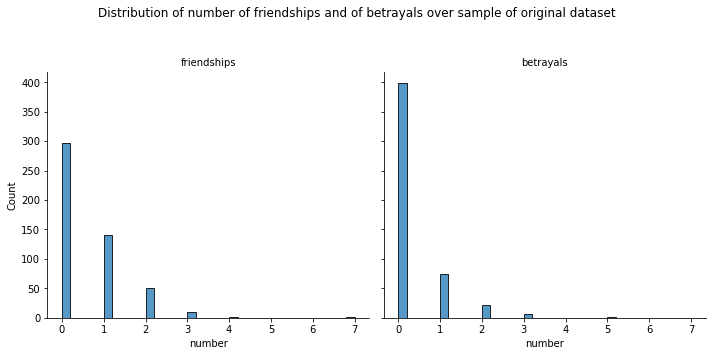

In [63]:
# make required the plot 
import seaborn as sns
g = sns.displot(data = frame, x = "number", kind = "hist", col = "type") ;
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Distribution of number of friendships and of betrayals over sample of original dataset") ; 
g.set_titles("{col_name}") ; 

if SAVE_PLOT:
    plt.savefig('plots/distribution_friendships.jpg')


## Final score plot

For each game, we want to have the final score of the betrayers, the victims and the neutrals.

In [64]:
# load the data to analyse
games_id = np.load("data/subset_T500_N1/games_id.npy")
all_friendships = np.load("data/subset_T500_N1/friendships.npy", allow_pickle=True)

scores = []

N = len(games_id)
for i in range(500):
    game_id = games_id[i]
    
    # reconstruct the obtained data
    data = all_friendships[i]
    years = np.arange(1901, 1901 + data.shape[0] * 0.5, 0.5)
    friendships = pd.DataFrame(data = all_friendships[i], columns = pairs, index = years)
    
    # get treatment 1 
    engageds = get_engageds(friendships)
    singles = get_singles(engageds)
    
    # get treatment 2
    betrayers, betrayeds = get_betrayers_and_betrayed(friendships)
    neutrals = get_neutrals(betrayers, betrayeds)
    
    # compute statistics
    for player in betrayers: 
        scores.append(("betrayer", all_players.query("game_id == @game_id & country == @player").num_supply_centers.item()))
    for player in betrayeds: 
        scores.append(("victim", all_players.query("game_id == @game_id & country == @player").num_supply_centers.item()))
    for player in neutrals: 
        scores.append(("neutral", all_players.query("game_id == @game_id & country == @player").num_supply_centers.item()))
        
frame = pd.DataFrame(data = scores, columns = ["status", "final_score"])

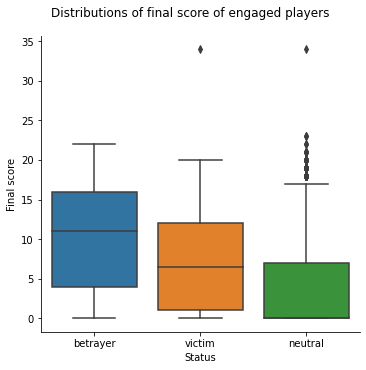

In [65]:
# make a plot using this 
g = sns.catplot(data = frame, y = "final_score", kind = "box", x = "status").set(
                xlabel='Status', 
                ylabel='Final score') ;  # , col = "status")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Distributions of final score of engaged players") ; 

if SAVE_PLOT:
    plt.savefig('plots/distribution_score.jpg')


We can see that, on average, engaging in a friendship and being betrayed lead to a better score than never being engaged in a friendship. 

## Games length distribution

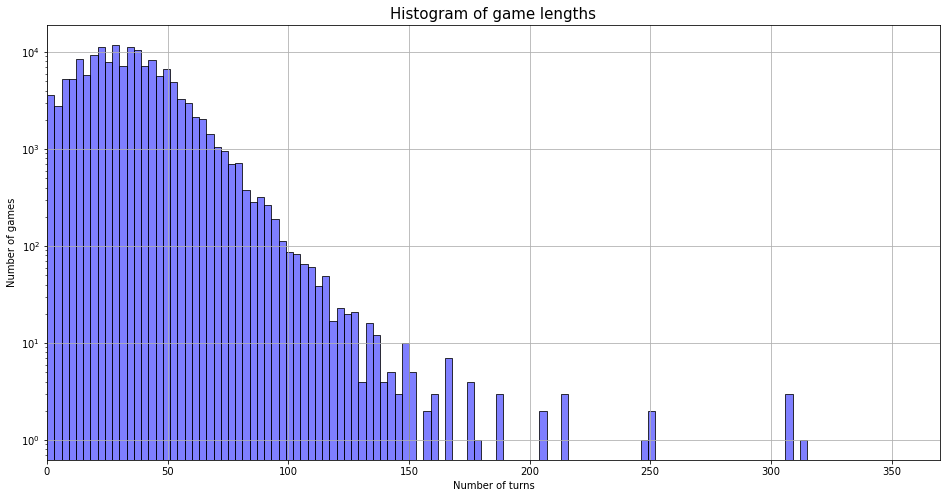

In [66]:
# Histogram of game lengths for the average player and for the winner

plt.figure(figsize=(16,8))                             
# winner_game_lengths =  all_players.sort_values('end_turn', ascending=False).drop_duplicates(['game_id'])
game_lengths = all_players.end_turn - all_players.start_turn

sns.histplot(game_lengths,
             alpha=0.5, 
             binwidth=3,
             color="blue")
# sns.histplot(winner_game_lengths["end_turn"], 
#              alpha=0.5, 
#              binwidth=3, 
#              color = "orange")
# plt.legend(["player","winner"])


plt.title("Histogram of game lengths", fontsize=15)
plt.xlabel("Number of turns")
plt.ylabel("Number of games")
plt.yscale("log")
plt.xlim(0,370 )
plt.grid(True)

if SAVE_PLOT:
    plt.savefig('plots/game_length_histogram.jpg')
plt.show()



Out of the 21,197 games, most of them last for about 30 turns but some can go up to 300 turns. 

## Distribution of friendly acts vs hostile acts

In [67]:
# sample of 500 games picked randomly from the original dataset
games_features = np.load("data/subset_T500_N1_unfiltered/games_features_id.npy", allow_pickle=True)
unfiltered_games_features = pd.DataFrame({'FriendlyActs': games_features[:, 0], 'HostileActs': games_features[:, 1]})
unfiltered_games_features.head()

,FriendlyActs,HostileActs
0,20,77
1,33,172
2,10,36
3,15,147
4,19,192


/Users/dianemarquette/opt/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/axisgrid.py:1629: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


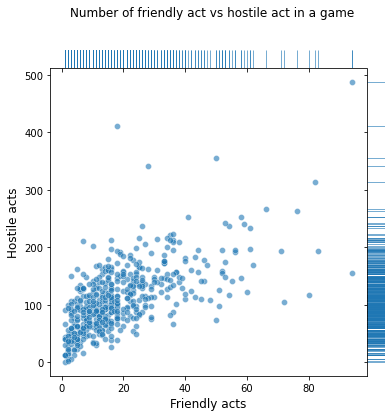

In [68]:
g = sns.JointGrid(data=unfiltered_games_features, x="FriendlyActs", y="HostileActs", space=0, ratio=17);
g.plot_joint(sns.scatterplot, sizes=(30, 120),
             palette="tab20c", alpha=.6, legend=False)
g.set_axis_labels('Friendly acts', 'Hostile acts', fontsize=12)

g.plot_marginals(sns.rugplot, height=1, palette="tab20c", alpha=.6);
plt.suptitle("Number of friendly act vs hostile act in a game")

if SAVE_PLOT:
    plt.savefig("plots/joint_distribution_friendact_hostilact.jpg")

In [69]:
games_features_melt = pd.melt(unfiltered_games_features, value_vars =['FriendlyActs', 'HostileActs'],
                             var_name='act_type', value_name='act_nb') 
games_features_melt.head()

,act_type,act_nb
0,FriendlyActs,20
1,FriendlyActs,33
2,FriendlyActs,10
3,FriendlyActs,15
4,FriendlyActs,19


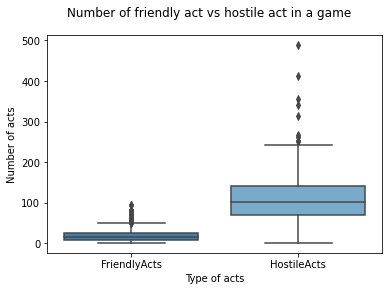

In [70]:
sns.boxplot(x="act_type", y="act_nb", palette="tab20c",
            data=games_features_melt).set(
                ylabel='Number of acts', 
                xlabel='Type of acts')
plt.suptitle("Number of friendly act vs hostile act in a game")

if SAVE_PLOT:
    plt.savefig("plots/joint_distribution_friendships_betrayals_boxplot.jpg")

## Serial betrayers

In [71]:
# load the data to analyse
games_id = np.load("data/subset_T500_N1/games_id.npy")
all_friendships = np.load("data/subset_T500_N1/friendships.npy", allow_pickle=True)

number_of_game_with_betrayals= 0

N = len(games_id)
print("Analysis of serial betraying")
for i, game_id in enumerate(games_id):
    # reconstruct the obtained data
    data = all_friendships[i]
    years = np.arange(1901, 1901 + data.shape[0] * 0.5, 0.5)
    friendships = pd.DataFrame(data = all_friendships[i], columns = pairs, index = years)
   
    # get treatment 2
    betrayers, _ = get_betrayers_and_betrayed(friendships)
    winners = get_winners(game_id)
    
    has_to_skip = False
    
    if len(betrayers) > 1:
        number_of_game_with_betrayals+=1
        for b in betrayers:
            if has_to_skip:
                continue
#             if np.count_nonzero([player == b for player in betrayers]) > 0: 
#                 print(game_id, "-  betrayers", betrayers, "winners : ", winners)
#                 has_to_skip = True
#                 number_of_game_with_betrayals += 1
            if np.count_nonzero([player == b for player in betrayers]) > 1: 
                print(game_id, "- serial betrayers", betrayers, "winners : ", winners)
                has_to_skip = True

Analysis of serial betraying
106950 - serial betrayers ['F', 'F'] winners :  ['F']
106794 - serial betrayers ['E', 'E'] winners :  ['T']
89613 - serial betrayers ['I', 'I'] winners :  ['I' 'A']
97720 - serial betrayers ['E', 'E', 'G', 'G'] winners :  ['T']
106058 - serial betrayers ['I', 'A', 'F', 'F'] winners :  ['F']
84945 - serial betrayers ['A', 'A'] winners :  ['E']
113564 - serial betrayers ['T', 'T'] winners :  ['F']
100109 - serial betrayers ['A', 'E', 'E'] winners :  ['F' 'T']
89658 - serial betrayers ['A', 'A'] winners :  ['A' 'T']


We can see here than on the 500 games we analysed. Only nine games contained a serial betrayer making it a rare occurence. Although the betrayer won in four out of the nine game, this sample size it too small to make any conclusion in regard to the win ratio of serial betrayers. In the most commun game, the betrayer one betrays once. 

## Games where a betrayer is betrayed

In [72]:
# load the data to analyse
games_id = np.load("data/subset_T500_N1/games_id.npy")
all_friendships = np.load("data/subset_T500_N1/friendships.npy", allow_pickle=True)

N = len(games_id)
for i, game_id in enumerate(games_id):
    # reconstruct the obtained data
    data = all_friendships[i]
    years = np.arange(1901, 1901 + data.shape[0] * 0.5, 0.5)
    friendships = pd.DataFrame(data = all_friendships[i], columns = pairs, index = years)
   
    # get treatment 2
    betrayers, betrayeds = get_betrayers_and_betrayed(friendships)
    winners = get_winners(game_id)
    
    
    if len(betrayers) > 1:
        for b in betrayers:
            if np.count_nonzero([player == b for player in betrayeds]) > 1: 
                print(game_id, "-  betrayers", betrayers, " - victims: ", betrayeds , " - winners : ", winners)

78412 -  betrayers ['A', 'E', 'R']  - victims:  ['R', 'R', 'T']  - winners :  ['E' 'R']


Out of the 500 games analysed, there is only one game where a betrayer is betrayed. 